<a href="https://colab.research.google.com/github/ramswaroopbhakar14/Upvotes-prediction/blob/master/Upvote_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/ramswaroopbhakar14/Upvotes-prediction.git

Cloning into 'Upvotes-prediction'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 29 (delta 11), reused 7 (delta 0), pack-reused 0
Unpacking objects: 100% (29/29), done.


In [2]:
%cd /content/Upvotes-prediction/data

/content/Upvotes-prediction/data


In [0]:
import pandas as pd
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

"creating copy of both train & test for further uses"
train_data1 = train_data.copy()
test_data1 = test_data.copy()

In [4]:
print("train columns:\n",train_data.columns)
print("test columns:\n",test_data.columns)

train columns:
 Index(['ID', 'Tag', 'Reputation', 'Answers', 'Username', 'Views', 'Upvotes'], dtype='object')
test columns:
 Index(['ID', 'Tag', 'Reputation', 'Answers', 'Username', 'Views'], dtype='object')


Print train & test head data

In [5]:
print("train sample:\n",train_data.head())
print("test sample:\n",test_data.head())

train sample:
        ID Tag  Reputation  Answers  Username    Views  Upvotes
0   52664   a      3942.0      2.0    155623   7855.0     42.0
1  327662   a     26046.0     12.0     21781  55801.0   1175.0
2  468453   c      1358.0      4.0     56177   8067.0     60.0
3   96996   a       264.0      3.0    168793  27064.0      9.0
4  131465   c      4271.0      4.0    112223  13986.0     83.0
test sample:
        ID Tag  Reputation  Answers  Username    Views
0  366953   a      5645.0      3.0     50652  33200.0
1   71864   c     24511.0      6.0     37685   2730.0
2  141692   i       927.0      1.0    135293  21167.0
3  316833   i        21.0      6.0    166998  18528.0
4  440445   i      4475.0     10.0     53504  57240.0


dropping non-important features

In [0]:
train_data = train_data1.drop(columns=['ID','Username'])
test_data = test_data1.drop(columns=['ID','Username'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


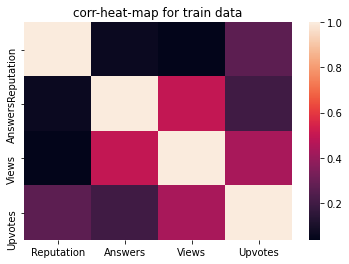

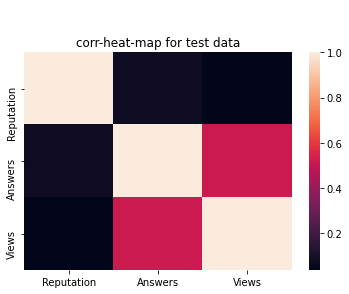

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure()
plt.title("corr-heat-map for train data")
"find correlation matrix"
train_corr = train_data.corr()
"generating heatmap using train_corr"
sns.heatmap(train_corr) # we don't see any var-pair haivng > 0.5 correlation, hence we'll be directly going for model building

plt.figure()
plt.title("\n\ncorr-heat-map for test data")
"find correlation matrix for test data"
test_corr = test_data.corr()
"generating heatmap using test_corr"
sns.heatmap(test_corr) 

Converting car=tegorical to numerical features ('Tag')

In [0]:
"Dealing with categorical features in a regression problem"

"First approach: to convert each category as sdummy variables"
#train_data = pd.concat([train_data.loc[:, train_data.columns!='Tag'], pd.get_dummies(train_data[['Tag']])], axis=1)
#test_data = pd.concat([test_data.loc[:, test_data.columns!='Tag'], pd.get_dummies(test_data[['Tag']])], axis=1)

"Second approach: to convert each category as a numerical label"
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_data['Tag']) # fitting label encoder for 'Tag'
train_data['Tag'] = le.transform(train_data['Tag']) # label transforming 'Tag' for train_data
test_data['Tag'] = le.transform(test_data['Tag']) # label transforming 'Tag' for test_data

In [41]:
print("train columns:\n",train_data.columns)
print("test columns:\n",test_data.columns)

train columns:
 Index(['Tag', 'Reputation', 'Answers', 'Views', 'Upvotes'], dtype='object')
test columns:
 Index(['Tag', 'Reputation', 'Answers', 'Views'], dtype='object')


In [42]:
print(train_data.head())
print(test_data.head())

   Tag  Reputation  Answers    Views  Upvotes
0    0      3942.0      2.0   7855.0     42.0
1    0     26046.0     12.0  55801.0   1175.0
2    1      1358.0      4.0   8067.0     60.0
3    0       264.0      3.0  27064.0      9.0
4    1      4271.0      4.0  13986.0     83.0
   Tag  Reputation  Answers    Views
0    0      5645.0      3.0  33200.0
1    1     24511.0      6.0   2730.0
2    3       927.0      1.0  21167.0
3    3        21.0      6.0  18528.0
4    3      4475.0     10.0  57240.0


In [43]:
"data pre-processing"
train_summary = train_data.describe()
test_summary = test_data.describe()

print(train_summary)
print(test_summary)

"missing data summary"
summary_na_train= [train_data[x].isna().sum() for x in train_data.columns] # we don't have any nan values in this data
summary_na_test= [test_data[x].isna().sum() for x in test_data.columns] # we don't have any nan values in this data

print(summary_na_train)
print(summary_na_test)

                Tag    Reputation        Answers         Views        Upvotes
count  330045.00000  3.300450e+05  330045.000000  3.300450e+05  330045.000000
mean        3.54305  7.773147e+03       3.917672  2.964507e+04     337.505358
std         2.49392  2.706141e+04       3.579515  8.095646e+04    3592.441135
min         0.00000  0.000000e+00       0.000000  9.000000e+00       0.000000
25%         1.00000  2.820000e+02       2.000000  2.594000e+03       8.000000
50%         4.00000  1.236000e+03       3.000000  8.954000e+03      28.000000
75%         6.00000  5.118000e+03       5.000000  2.687000e+04     107.000000
max         9.00000  1.042428e+06      76.000000  5.231058e+06  615278.000000
                 Tag    Reputation        Answers         Views
count  141448.000000  1.414480e+05  141448.000000  1.414480e+05
mean        3.552542  7.920927e+03       3.914873  2.984633e+04
std         2.494553  2.791072e+04       3.577460  8.034374e+04
min         0.000000  0.000000e+00       0

Generating some discrete features from continuous features

In [0]:
from sklearn.preprocessing import Binarizer

#for 'Reputation'
bn_repu = Binarizer(threshold=1e4)
repu_train = bn_repu.transform([train_data['Reputation']])[0]
train_data['Repu_grade'] = repu_train
repu_test = bn_repu.transform([test_data['Reputation']])[0]
test_data['Repu_grade'] = repu_test

#for 'Answers'
bn_ans = Binarizer(threshold=7)
ans_train = bn_ans.transform([train_data['Answers']])[0]
train_data['Answer_grade'] = ans_train
ans_test = bn_ans.transform([test_data['Answers']])[0]
test_data['Answer_grade'] = ans_test

#for 'Views'
bn_view = Binarizer(threshold=3e4)
view_train = bn_view.transform([train_data['Views']])[0]
train_data['View_grade'] = view_train
view_test = bn_view.transform([test_data['Views']])[0]
test_data['View_grade'] = view_test

Box-plots of train-test data & data selection

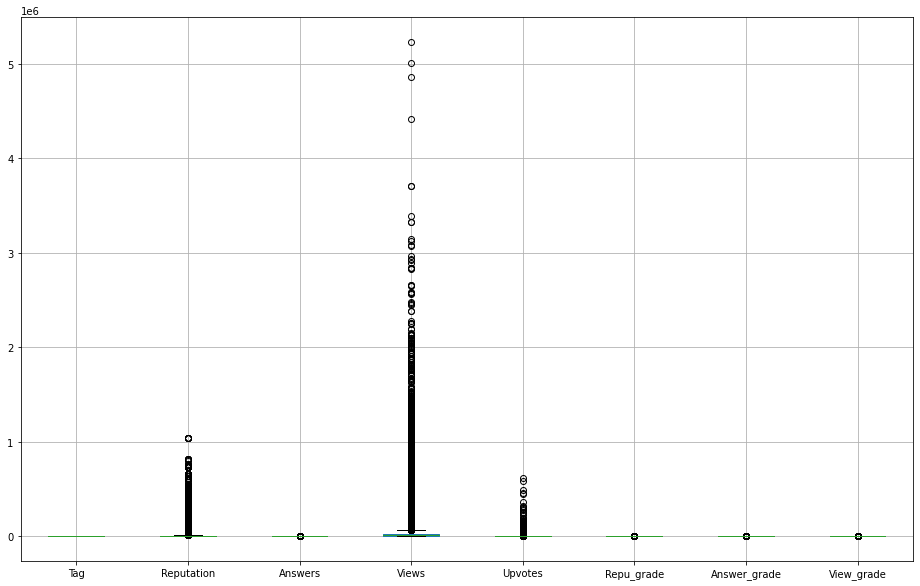

In [45]:
"train box-plot"
plt.figure(figsize=[16,10])
train_data.boxplot()

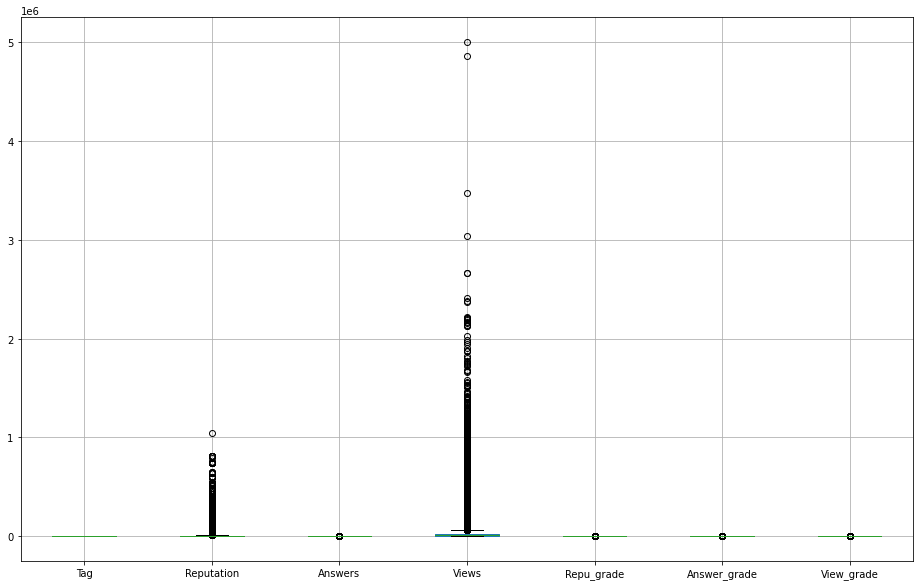

In [46]:
"test box-plot"
plt.figure(figsize=[16,10])
test_data.boxplot()

treating outliers of training data for better model fitment

train shape before outlier removal: (330045, 8)
train shape after 1st outlier treatment: (330039, 8)
train shape after 1st outlier treatment: (330011, 8)


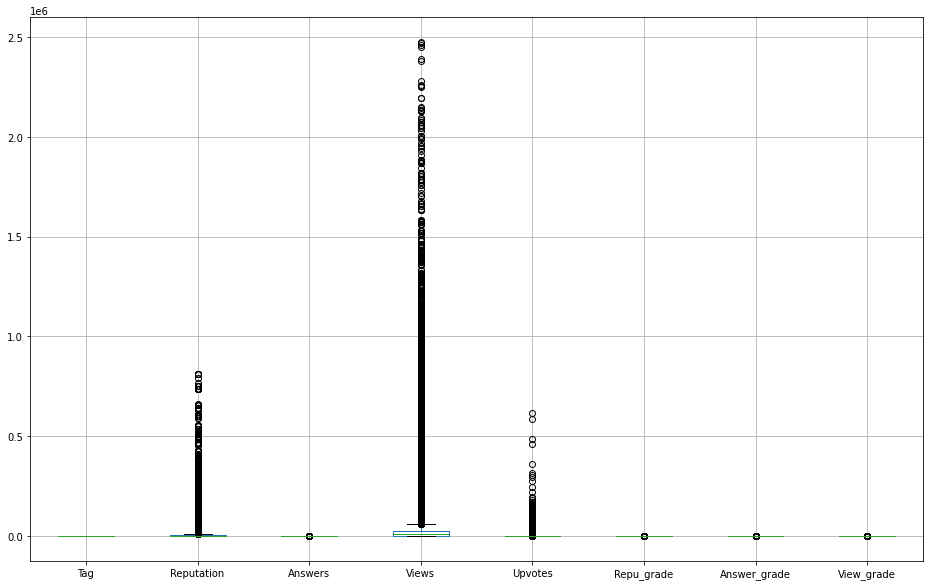

In [47]:
"First approach: we have tried with below approach but it's not good for test data"
# from scipy import stats
# "we'll drop those values of a columns where (value>97.85th percentile of that columns) or (value<0.13 percentile of that columns)"
# train_data = train_data[(np.abs(stats.zscore(train_data)) < 3).all(axis=1)]
# "train box-plot"
# plt.figure(figsize=[16,10])
# train_data.boxplot()

print('train shape before outlier removal:', train_data.shape)
"second approach: we'll be manually removing some values which are not much observed in test data"
#1st: drop rows where 'Reputation' is > 1e6"
train_data = train_data.drop(train_data[train_data.Reputation>1e6].index).reset_index(drop=['index'])
print('train shape after 1st outlier treatment:', train_data.shape)

#2nd: drop rows where 'Reputation' is > 2.5e6"
train_data = train_data.drop(train_data[train_data.Views>2.5*1e6].index).reset_index(drop=['index'])
print('train shape after 1st outlier treatment:', train_data.shape)

"train box-plot after some manual outlier treatments"
plt.figure(figsize=[16,10])
train_data.boxplot()

Feature standardization scaling

In [0]:
from sklearn.preprocessing import StandardScaler
"fitting & transforming on train data"
sc_fit = StandardScaler().fit(train_data.iloc[:, train_data.columns!='Upvotes'].values)
train_input_scaled = sc_fit.transform(train_data.iloc[:, train_data.columns!='Upvotes'].values)
"transforming on test data"
test_input_scaled = sc_fit.transform(test_data.values)

In [49]:
print('scaled train data inputs:\n',train_input_scaled[:2])
print('scaled test data inputs:\n',test_input_scaled[:2])

scaled train data inputs:
 [[-1.42066933 -0.14273714 -0.53658222 -0.28670098 -0.42553299 -0.34495825
  -0.54383485]
 [-1.42066933  0.68513886  2.26474908  0.35212432  2.34999407  2.89890156
   1.83879353]]
scaled test data inputs:
 [[-1.42066933 -0.07895353 -0.25644909  0.05099199 -0.42553299 -0.34495825
   1.83879353]
 [-1.01969596  0.62764747  0.5839503  -0.35498571  2.34999407 -0.34495825
  -0.54383485]]


Standard scaling of datasets

In [0]:
"splitting train-test data"
from sklearn.model_selection import train_test_split


input_features = train_input_scaled
target = train_data['Upvotes'].values

X_train, X_val, y_train, y_val = train_test_split(input_features, target, test_size=0.1, random_state=10)


"ML models"
# we'll try 6 different models to get best model with best hyper-parameters
# will use gridsearchcv o randomizedsearchcv for parameter optimization
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoLars, Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.svm import SVR

poly = PolynomialFeatures(4)

lrr = Ridge()
llr1 = Lasso()
llr = LassoLars()
knn = KNeighborsRegressor()
rfr = RandomForestRegressor()
xgbr = XGBRegressor()
svr = SVR()

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error as mse

algos = [lrr, llr1, llr, knn, svr, rfr, xgbr]
grid_params = {lrr: {'alpha':[0,0.005,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.1,0.2,0.5,1,2,5,10]},
                llr1: {'alpha':[0,0.005,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.1,0.2,0.5,1,2,5,10]},
                 llr: {'alpha':[0,0.005,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08, 0.09,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,1,2,5,10]},
                 knn:{'n_neighbors':[1,3,5,11,15,17,20,30,40,50,70],'weights':['uniform','distance'],'metric':['euclidean','manhattan']},
                 svr:{'C': [0.1, 1, 10, 100, 1000],'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
                  rfr: {'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)],# Number of trees in random forest
                                                 'max_features': ['auto', 'sqrt',None],# Number of features to consider at every split
                                                 'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)]+[None],# Maximum number of levels in tree
                                                 'min_samples_split': [2, 5, 10],# Minimum number of samples required to split a node
                                                 'min_samples_leaf': [1, 2, 4],# Minimum number of samples required at each leaf node
                                                 'bootstrap': [True, False]},# Method of selecting samples for training each tree
                 xgbr:{'eta':[0.1,0.3,0.5,0.7],'gamma':[0,10,100],'max_depth':[1,3,5,9,11]}}                                     


In [58]:
xgbr.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)>

In [59]:
#%%
import time
scoring='neg_mean_squared_error'
cv_results_list = []
best_params_list = []
best_cv_rmse_list = []
val_rmse_list = []
train_time_list = []
for algo in algos[-1:]:
    num_iter = 2
    st = time.time()
#    model = GridSearchCV(knn, grid_params[knn], n_jobs=-1, scoring=scoring) # not performing gridsearchcv as it takes lot time
    total_param_combinations = np.prod([len(grid_params[algo][par]) for par in list(grid_params[algo].keys())])
    print("train param, combinations:\n",total_param_combinations)
    
    if (algo==llr) | (algo==lrr) | (algo==llr1):
        X_train1 = poly.fit_transform(X_train)
        model = GridSearchCV(estimator=algo, cv=3, scoring=scoring,n_jobs=-1, param_grid=grid_params[algo], refit=True)
        model.fit(X_train1, y_train)
    elif (algo==xgbr):
        model = XGBRegressor()
        model.fit(X_train, y_train)
    else:
        model = RandomizedSearchCV(estimator=algo, n_iter=num_iter, cv=3, scoring=scoring,n_jobs=-1, param_distributions=grid_params[algo], refit=True)
        model.fit(X_train, y_train)
    
    
    cv_results_list+=[model.cv_results_]
    
    best_cv_rmse1 = np.sqrt(-max(model.cv_results_['mean_test_score']))
    best_cv_rmse_list+=[best_cv_rmse1]
    
    best_params_list+=[model.best_params_]
    
    train_time1 = str(round(time.time()-st,2))+' seconds'
    train_time_list+=[train_time1]
    if (algo==llr) | (algo==lrr) | (algo==llr1):
        X_val1 = poly.transform(X_val)
        y_pred = model.predict(X_val1)
    else:
        y_pred = model.predict(X_val)
    
    rmse1 = np.sqrt(mse(y_val,y_pred))
        
    val_rmse_list+=[rmse1]
    
    print('total_cv_time:',train_time1)
    print('avg_cv_rmse:',best_cv_rmse1)
    
    print('val_rmse:', rmse1)

    print("best params", best_params_list[-1])

train param, combinations:
 60
[18:49:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
total_cv_time: 8.69 seconds
val_rmse: 1435.8436020173715


prediction on test data

In [52]:
test_data.columns

Index(['Tag', 'Reputation', 'Answers', 'Views', 'Repu_grade', 'Answer_grade',
       'View_grade'],
      dtype='object')

In [0]:
X_test = test_input_scaled
if algo==llr:
  X_test1 = poly.transform(X_test)
  final_pred = model.predict(X_test1)
else:  
  final_pred = model.predict(X_test)
final_submission = pd.DataFrame({'ID':list(test_data1.ID),'Upvotes':list(final_pred)})

In [0]:
final_submission.to_csv('upvotes_8th_submission_llr4_20_outlier_treatmet_manual.csv', index=False)